This notebook contains a showcase of some of the various models used in Chapter 5 of the PhD thesis of Jasper Marijn Everink on "Uncertainty Quantification for Inverse Problems with Sparsity-Promoting Implicit Priors"

# Set-up

In [1]:
# Load modules and set-up test problem
import sys
# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from cuqi.distribution import JointDistribution, Gaussian, GMRF, Gamma, ModifiedHalfNormal
from cuqi.implicitprior import RegularizedGMRF, NonnegativeGMRF, ConstrainedGMRF, RegularizedUniform
from cuqi.model import LinearModel
from cuqi.geometry import Continuous1D

from cuqi.sampler import RegularizedLinearRTO, LinearRTO, Gibbs, Conjugate

np.random.seed(24601)

In [2]:
# -- This is a temporary feature that won't be necesarry in later versions of CUQIpy
# Create a new sampler class with preset parameters
def make_RegularizedLinearRTO(x0 = None, maxit = 100, stepsize = "automatic", tradeoff = 10.0, adaptive = True):
    # Wrapper to tune the parameters
    class _RegularizedLinearRTO(RegularizedLinearRTO):
        def __init__(self, target):
            super().__init__(target, x0=x0, maxit=maxit, stepsize = stepsize, tradeoff = tradeoff, adaptive = adaptive)

    return _RegularizedLinearRTO

In [3]:
from generate_data import gen_problem

n = 128

A_mat, y_data, exactSolution = gen_problem()
A = LinearModel(A_mat, domain_geometry=Continuous1D(128), range_geometry=Continuous1D(128))

In [4]:
# Visualize the samples
def plot_uq(samples, save_name=None):
    fg_rows = 6
    fg_cols =  9
    fg = (fg_rows, fg_cols)

    sub_cols = 6
    sub_rows = 4

    plt.figure(layout="constrained", figsize=(fg_cols, fg_rows))

    ax1 = plt.subplot2grid(fg, (0, 0), colspan=sub_cols, rowspan=sub_rows)
    ax2 = plt.subplot2grid(fg, (sub_rows, 0), colspan=sub_cols, rowspan=fg_rows-sub_rows)
    ax3 = plt.subplot2grid(fg, (0, sub_cols), colspan=fg_cols-sub_cols, rowspan=int(fg_rows/2))
    ax4 = plt.subplot2grid(fg, (int(fg_rows/2), sub_cols), colspan=fg_cols-sub_cols, rowspan=int(fg_rows/2))

    plt.sca(ax1)
    samples['x'].plot_ci()
    plt.plot(exactSolution)

    plt.sca(ax2)
    samples['x'].plot_ci_width()
    plt.ylim([0, 0.65])

    plt.sca(ax3)
    plt.hist(samples['l'].samples.flatten(), bins = 100, density=True)
    plt.legend([r'$\lambda$'])
    plt.title(r"Histogram of $\lambda$")

    plt.sca(ax4)
    plt.hist(samples['d'].samples.flatten(), bins = 100, density=True)
    plt.legend([r'$\delta$'])
    plt.title(r"Histogram of $\delta$")

    if save_name is not None:
        plt.savefig(save_name)

    plt.show()

# Model: reference

Warmup 10 / 10
Sample 1000 / 1000


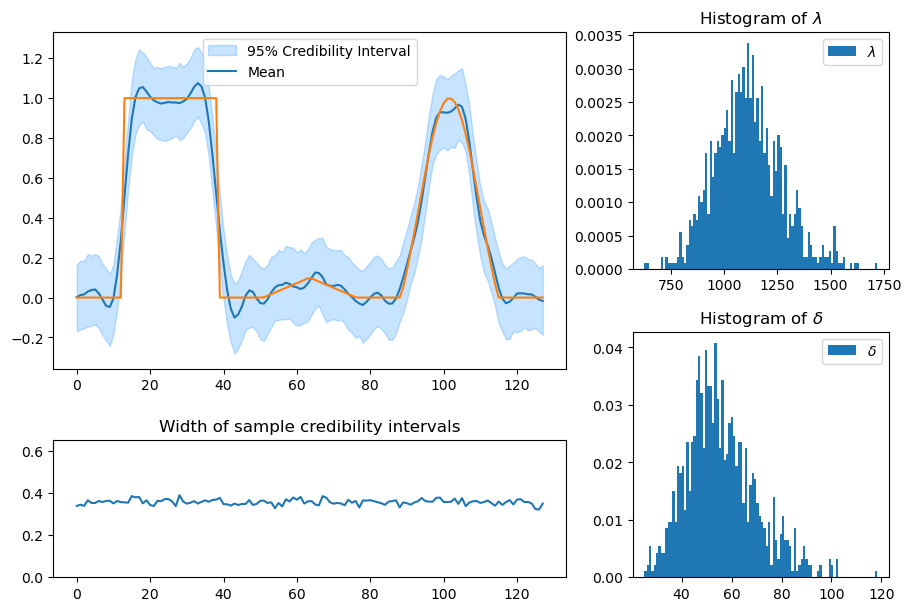

In [5]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = GMRF(mean = np.zeros(n), prec = lambda d : d)
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)


sampling_strategy = {
    'x': LinearRTO,
    'l': Conjugate,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 10)

plot_uq(samples)

# Model: nonnegativity

Warmup 10 / 10
Sample 1000 / 1000


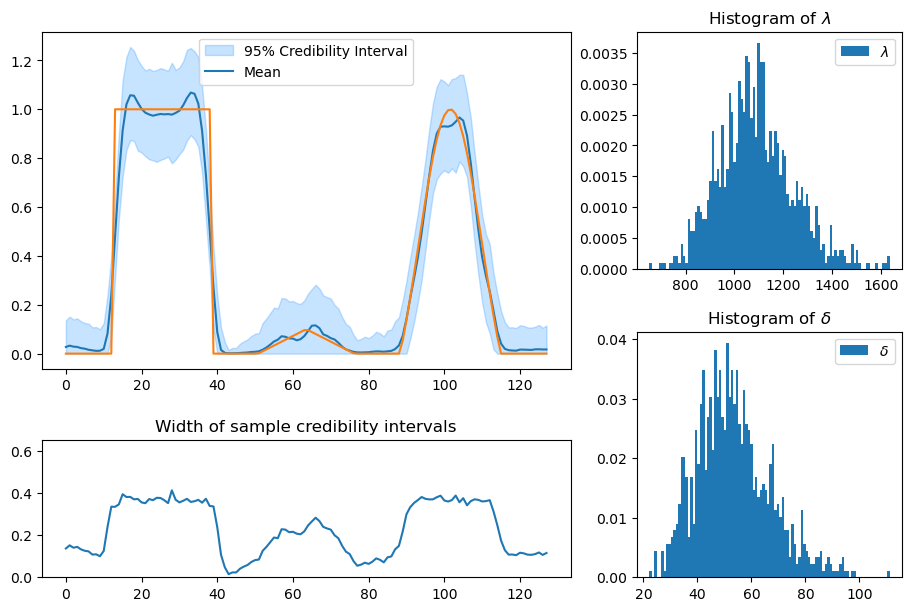

In [6]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = NonnegativeGMRF(mean = np.zeros(n), prec = lambda d : d)
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': Conjugate,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 10)

plot_uq(samples)

# Model: box

Warmup 10 / 10
Sample 1000 / 1000


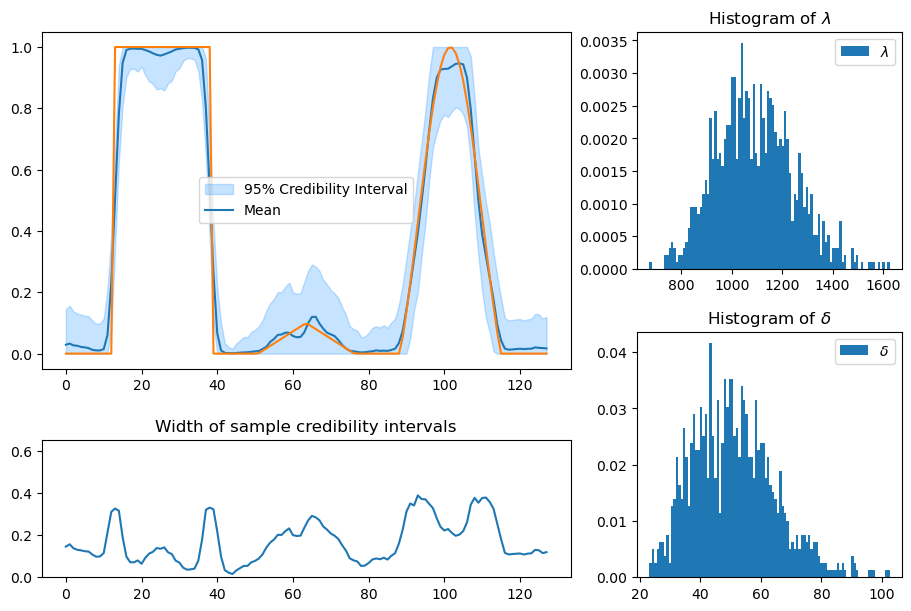

In [7]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = ConstrainedGMRF(mean = np.zeros(n), prec = lambda d : d, constraint = "box", lower_bound = 0, upper_bound = 1)
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': Conjugate,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 10)

plot_uq(samples)

# Model: $l_1$ bound

Warmup 10 / 10
Sample 3000 / 3000


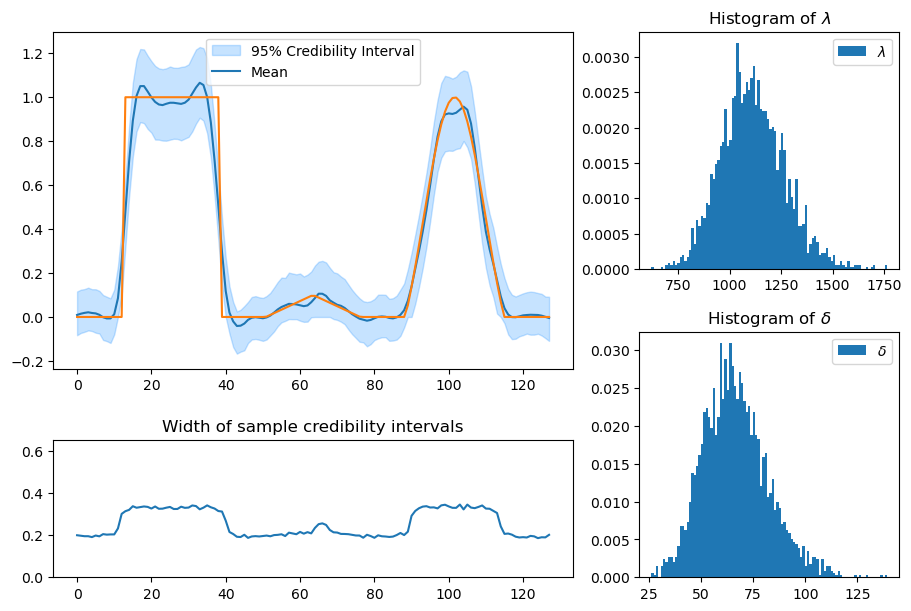

In [8]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = ConstrainedGMRF(mean = np.zeros(n), prec = lambda d : d, constraint = "l1", radius = np.linalg.norm(y_data, ord = 1))
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': Conjugate,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(3000, 10)

plot_uq(samples)

# Model: simplex constraint

Warmup 10 / 10
Sample 3000 / 3000


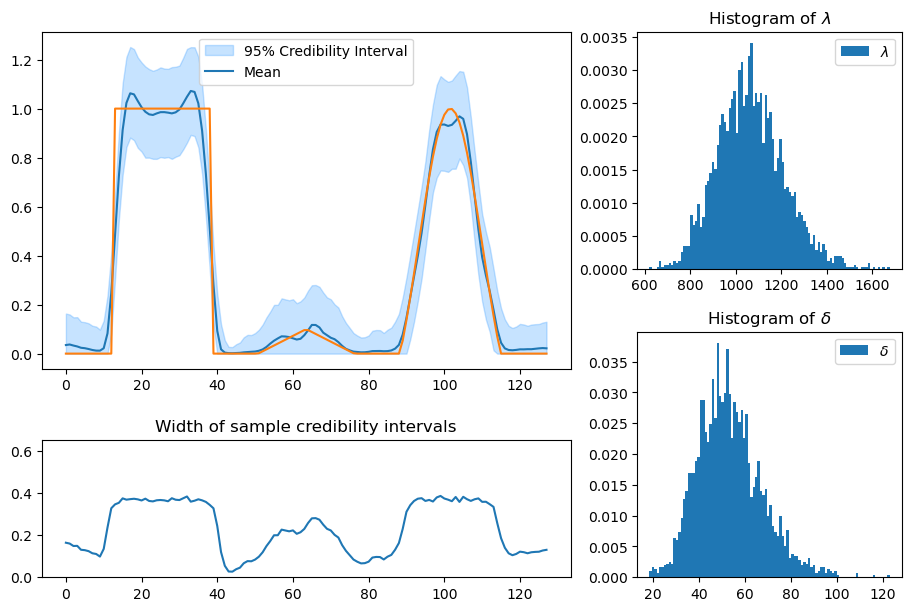

In [9]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = ConstrainedGMRF(mean = np.zeros(n), prec = lambda d : d, constraint = "simplex", radius = np.linalg.norm(y_data, ord = 1))
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': Conjugate,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(3000, 10)

plot_uq(samples)

# Model: $l_2$ bound

Warmup 10 / 10
Sample 3000 / 3000


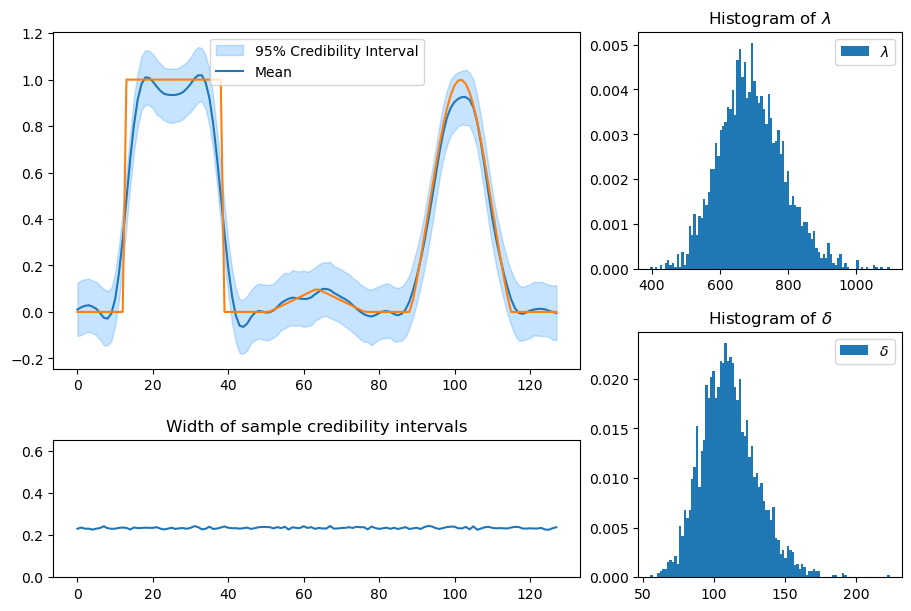

In [10]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = ConstrainedGMRF(mean = np.zeros(n), prec = lambda d : d, constraint = "l2", radius = np.linalg.norm(y_data, ord = 2))
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': Conjugate,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(3000, 10)


plot_uq(samples)

# Model: TV with Gamma hyperprior
"RuntimeWarning: divide by zero encountered" is expected

c:\Users\jmev\Documents\Thesis_code\git_final\Thesis-JME\cuqi\distribution\_gaussian.py:681: RuntimeWarning: divide by zero encountered in log
  logdet = np.sum(-np.log(precision))


Warmup 10 / 10
Sample 1000 / 1000


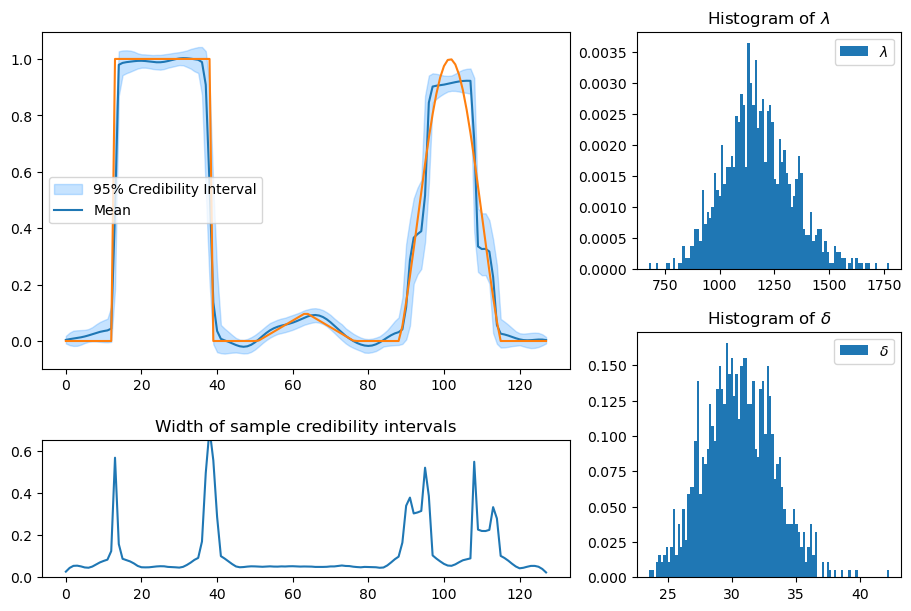

In [11]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedUniform(A.domain_geometry,
                       regularization = "TV", strength = lambda d : d)
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': make_RegularizedLinearRTO(x0=None, maxit=100, tradeoff = 10.0, adaptive = False),
    'l': Conjugate,
    'd': Conjugate,
}


sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 10)

plot_uq(samples)

# Model: TV with Modified Halfnormal hyperprior
"RuntimeWarning: divide by zero encountered" is expected

Warmup 10 / 10
Sample 1000 / 1000


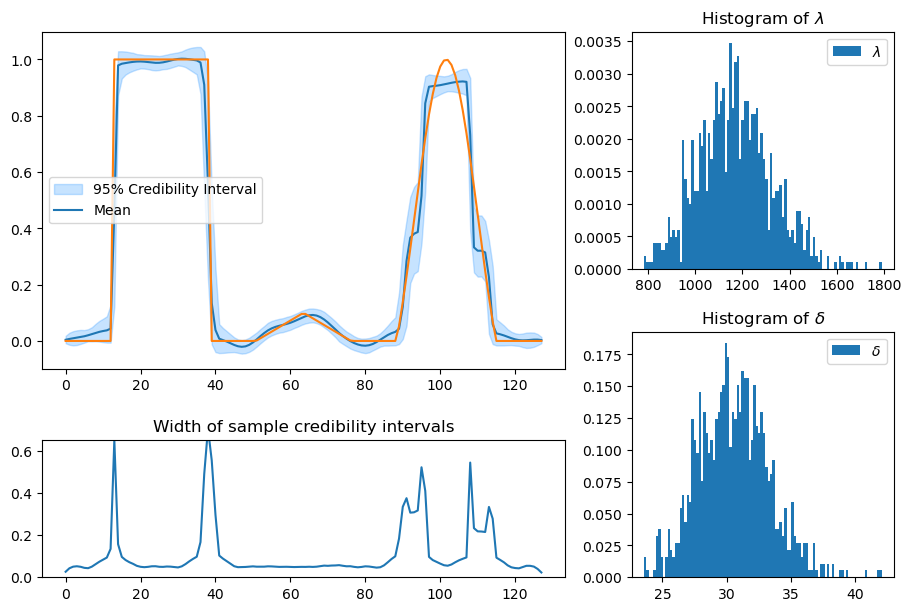

In [12]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = ModifiedHalfNormal(1, 1e-4, -1e-4)
x = RegularizedGMRF(mean = np.zeros(n), prec = lambda d : 2.4e-4*d**2,
                    regularization = "TV", strength = lambda d : d,
                    geometry = A.domain_geometry,)
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': make_RegularizedLinearRTO(x0=None, maxit=100, tradeoff = 10.0, adaptive = False),
    'l': Conjugate,
    'd': Conjugate,
}


sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 10)

plot_uq(samples)

# Model: Nonnegativity constrained TV with Modified Halfnormal hyperprior
"RuntimeWarning: divide by zero encountered" is expected

Warmup 10 / 10
Sample 1000 / 1000


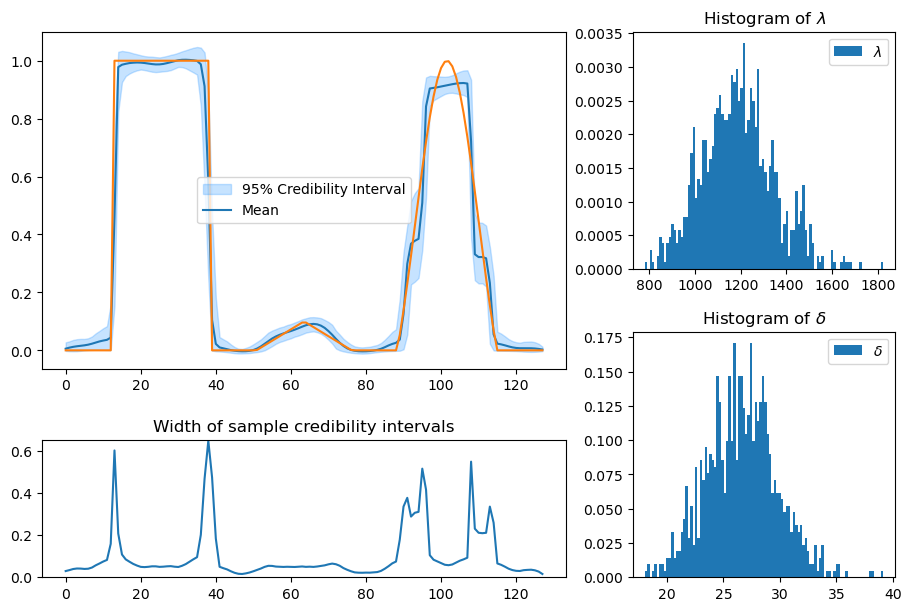

In [13]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = ModifiedHalfNormal(1, 1e-4, -1e-4)
x = RegularizedGMRF(mean = np.zeros(n), prec = lambda d : 2.4e-4*d**2,
                    regularization = "TV", strength = lambda d : d,
                    constraint = "nonnegativity",
                    geometry = A.domain_geometry,)
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': make_RegularizedLinearRTO(x0=None, maxit=100, tradeoff = 10.0, adaptive = False),
    'l': Conjugate,
    'd': Conjugate,
}


sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 10)

plot_uq(samples)

# Model: Box constrained TV with Modified Halfnormal hyperprior
"RuntimeWarning: divide by zero encountered" is expected

Warmup 10 / 10
Sample 1000 / 1000


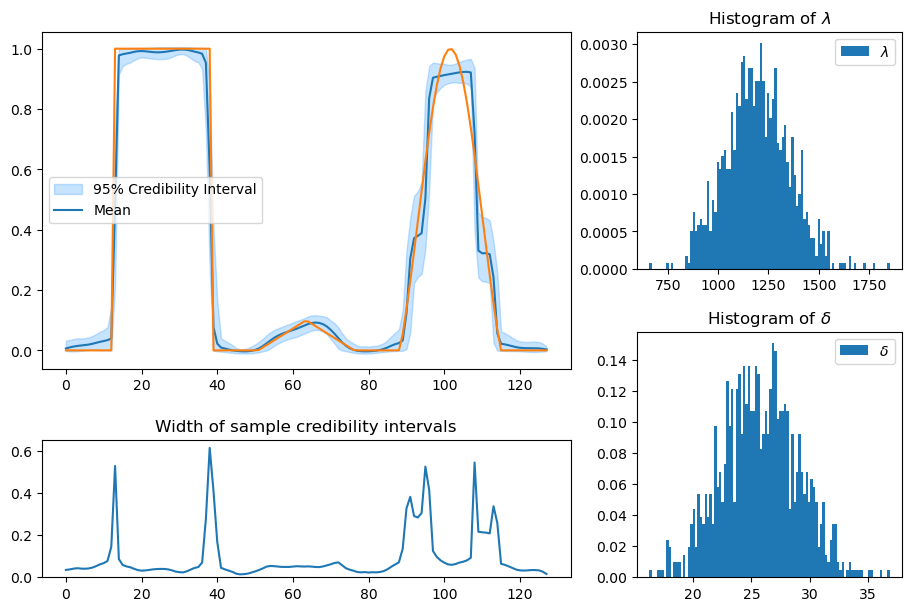

In [15]:
np.random.seed(24601)

l = Gamma(1, 1e-4)
d = ModifiedHalfNormal(1, 1e-4, -1e-4)
x = RegularizedGMRF(mean = np.zeros(n), prec = lambda d : 2.4e-4*d**2,
                    regularization = "TV", strength = lambda d : d,
                    constraint = "box", lower_bound = 0.0, upper_bound = 1.0,
                    geometry = A.domain_geometry,)
y = Gaussian(A@x, prec = lambda l : l)

joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': make_RegularizedLinearRTO(x0=None, maxit=100, tradeoff = 10.0, adaptive = False),
    'l': Conjugate,
    'd': Conjugate,
}


sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 10)

plot_uq(samples)